In [1]:
#from diff_predictor import data_process #comment this out if it causes issue - function is called below
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

In [49]:
def balance_data(df, target, **kwargs):
    """
    Balance spatial data using undersampling. Assumes input will
    be a dataframe and data will be used for categorical classification
    Parameters
    ----------
    df : pandas.DataFrame
        pandas dataframe to be balanced
    target : string
        the name of the target/tag/y-value column to balance data around
        
    Optional Parameters
    -------------------
    random_state : int : 1
        seed to base random sampling from
    Returns
    -------
    A fully balanced pandas dataframe
    """
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance " +
          f"({':'.join([str(i[0]) for i in df_target])}) = " +
          f"{':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio,
                                             random_state=random_state))
    print(f"Ratio after balance " +
          f"({':'.join([str(i[0]) for i in df_target])}) = " +
          f"{':'.join([str(len(i)) for i in bal_df])}")
    assert len(bal_df) > 0, 'DataFrame cant be empty'
    return pd.concat(bal_df)

In [80]:
def generate_fullstats(dataset_path, filelist, targets, target_col_name='Target'):
    """
    Generates single csv of all statatistics from list of files
    Parameters
    ---------
    dataset_path: string
        string of path to folder containing data files
    filelist: list
        list containing filenames of all files to be processed
    targets: list
        list containing strings that state which class/group a file is from,
        string must be in the filename of the data files
    Target: string
        
    Returns
    -------
    fstats_tot: pandas.DataFrame
        dataframe containing all rows from data files and with new column
        for the class/group the row came from
    """
    fstats_tot = None
    video_num = 0
    for filename in filelist:
            fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            #print('{} size: {}'.format(filename, fstats.shape))
            
            for i in range(0, len(targets)):
                if targets[i] in filename:
                    print('Adding file {} size: {}'.format(filename, fstats.shape))
                    fstats[target_col_name] = pd.Series(fstats.shape[0]*[targets[i]], index=fstats.index)
                    fstats['Filename'] = pd.Series(fstats.shape[0]*[filename], index=fstats.index)
                    fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
                    if fstats_tot is None:
                        fstats_tot = fstats
                    else:
                        fstats_tot = fstats_tot.append(fstats, ignore_index=True)
                    video_num += 1
                    #break

            
    return fstats_tot

In [5]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [7]:
# You will have to change the data_path to what your own path to the data is to get it to run for you
data_path = workbookDir + '/data/Brendan_traj_data/'
filelist = [f for f in listdir(data_path) if isfile(join(data_path, f)) and 'feat' in f]
print(len(filelist))

6


In [87]:
#the list of ['NT', '1uM', '5uM'] tells the function what classes/groups you want to split the data up by
# In this case its split by treatment, so to split by time you could have:
#   generate_fullstats(data_path, filelist, targets=['4DIV', '7DIV', '10DIV', target_col_name = 'time])
fstats_tot = generate_fullstats(data_path, filelist, targets=['NT', '1uM', '5uM'], target_col_name='treatment')
target = 'treatment' #for time analysis, would want to change this to whatever target_col_name is set to

Adding file features_P10F_NT_4DIV_40nm_slice_1_cortex_vid_1.csv size: (2091, 68)
Adding file features_P10F_5uM_7DIV_40nm_slice_1_midbrain_vid_2.csv size: (742, 68)
Adding file features_P10F_5uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (2405, 68)
Adding file features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (638, 68)
Adding file features_P10F_1uM_10DIV_40nm_slice_1_cortex_vid_1.csv size: (2418, 68)
Adding file features_P10F_5uM_10DIV_40nm_slice_1_cortex_vid_2.csv size: (1481, 68)


In [83]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

In [84]:
ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(9775, 36)


(8679, 36)

In [85]:
bal_ecm = balance_data(ecm, target)
labels = ['NT', '1uM', '5uM']

Ratio before data balance (NT:5uM:1uM) = 1922:4091:2666
Ratio after balance (NT:5uM:1uM) = 1922:1922:1922


Text(0.5, 0.98, 'Distributions of Fractal Dimension')

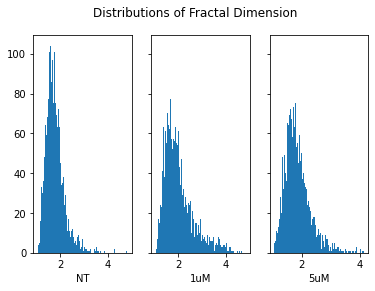

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

for i, group in enumerate(labels):
    df = bal_ecm[bal_ecm[target]==labels[i]]
    fracdim_arr = df['fractal_dim'].values
    ax[i].hist(fracdim_arr, histtype='bar', bins=100) # histtype and bins parameters can 
                                                      #be played with: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    ax[i].set_xlabel(group)
plt.suptitle('Distributions of Fractal Dimension')

Text(0.5, 0.98, 'Distributions of Alpha')

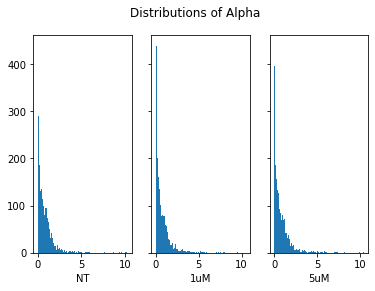

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

for i, group in enumerate(labels):
    df = bal_ecm[bal_ecm[target]==labels[i]]
    alpha_arr = df['alpha'].values
    ax[i].hist(alpha_arr, histtype='bar', bins=100) # histtype and bins parameters can 
                                                      #be played with: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    ax[i].set_xlabel(group)
plt.suptitle('Distributions of Alpha')

Text(0.5, 0.98, 'Distributions of log(Alpha)')

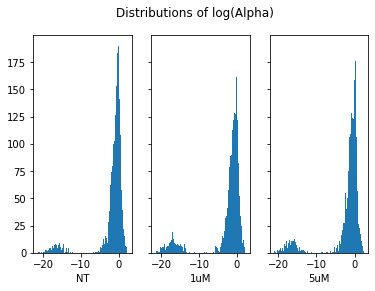

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

for i, group in enumerate(labels):
    df = bal_ecm[bal_ecm[target]==labels[i]]
    alpha_arr = df['alpha'].values
    ax[i].hist(np.log(alpha_arr), histtype='bar', bins=100) # histtype and bins parameters can 
                                                      #be played with: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    ax[i].set_xlabel(group)
plt.suptitle('Distributions of log(Alpha)')

(0.0, 1.0)

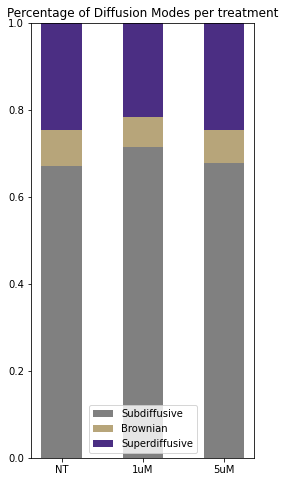

In [88]:
fig = plt.figure(figsize=(4,8))

directed_percent = np.zeros(len(labels))
normal_percent = np.zeros(len(labels))
constrained_percent = np.zeros(len(labels))
immobilized_percent = np.zeros(len(labels))

for i, unique_class in enumerate(labels):
    
    df = bal_ecm[bal_ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.1]
    directed_percent[i] = (len(directed_df)/len(df))

    normal_df = df[(df['alpha'] <= 1.1) & (df['alpha'] >= 0.9)]
    normal_percent[i] = (len(normal_df)/len(df))
    
    constrained_df = df[(df['alpha'] < 0.9)]
    constrained_percent[i] = (len(constrained_df)/len(df))
    
    #immobilized_df = df[(df['alpha'] <= 0.1)]
    #immobilized_percent[i] = (len(immobilized_df)/len(df))
    
    
#plt.bar(labels, immobilized_percent, color='r', label='immobilized')
bar_w = 0.5
plt.bar(labels, constrained_percent, label='Subdiffusive', width=bar_w, color='grey')
plt.bar(labels, normal_percent, bottom=constrained_percent+immobilized_percent, color='#b7a57a', label='Brownian', width=bar_w)
plt.bar(labels, directed_percent, bottom=constrained_percent+immobilized_percent+normal_percent, color='#4b2e83', label='Superdiffusive', width=bar_w)
plt.ylim([0,1])
plt.legend()
plt.title(f'Percentage of Diffusion Modes per {target}')
plt.ylim([0,1])